In [1]:
#! pip3 install -U jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip3 install -r "/content/drive/MyDrive/datasets/requirements2.txt"

In [3]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# MobileNeRF

In [4]:
# Copyright 2023 The jax3d Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import jax
import flax
import optax
scene_type = "synthetic"
object_name = "chair"
scene_dir = "/content/drive/MyDrive/datasets/"+object_name

# synthetic
# chair drums ficus hotdog lego materials mic ship

# forwardfacing
# fern flower fortress horns leaves orchids room trex

# real360
# bicycle flowerbed gardenvase stump treehill
# fulllivingroom kitchencounter kitchenlego officebonsai

#%% --------------------------------------------------------------------------------
# ## General imports
#%%
import copy
import gc
import json
import os
import numpy
import cv2
from tqdm import tqdm
import pickle
import jax
import jax.numpy as np
from jax import random
import flax
import flax.linen as nn
import functools
import math
from typing import Sequence, Callable
import time
import matplotlib.pyplot as plt
from PIL import Image
from multiprocessing.pool import ThreadPool

print(jax.local_devices())
if len(jax.local_devices())!=8:
  print("ERROR: need 8 v100 GPUs")
  #1/0
weights_dir = "/content/drive/MyDrive/datasets/weights"
samples_dir = "/content/drive/MyDrive/datasets/samples"
if not os.path.exists(weights_dir):
  os.makedirs(weights_dir)
if not os.path.exists(samples_dir):
  os.makedirs(samples_dir)
def write_floatpoint_image(name,img):
  img = numpy.clip(numpy.array(img)*255,0,255).astype(numpy.uint8)
  cv2.imwrite(name,img[:,:,::-1])

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


## Load Datasets

Step test load dataset
train
  images: (51, 800, 800, 3)
  c2w: (51, 4, 4)
  hwf: (3,)
test
  images: (101, 800, 800, 3)
  c2w: (101, 4, 4)
  hwf: (3,)


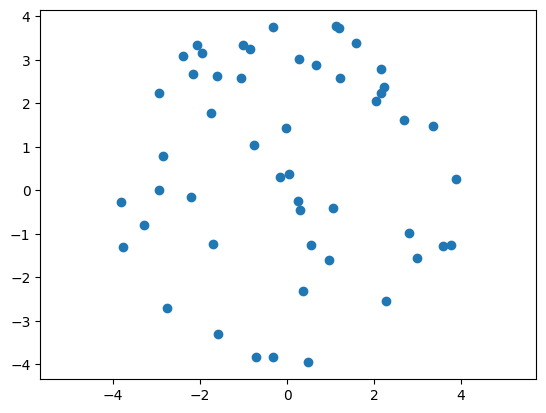

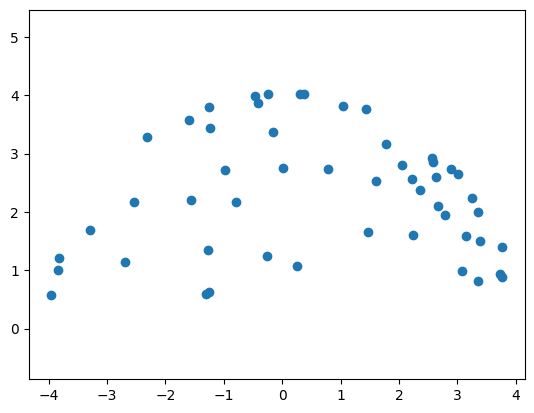

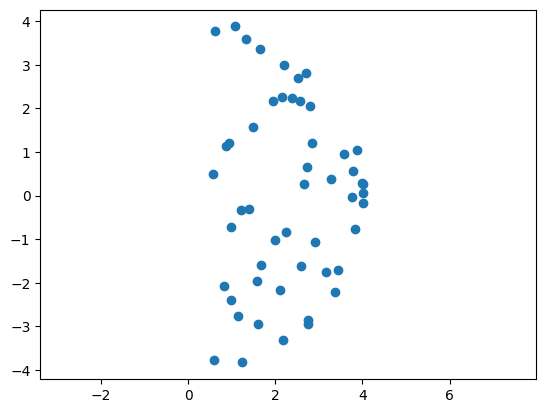

In [5]:

#%% --------------------------------------------------------------------------------
# ## Load the dataset
#%%
# """ Load dataset """

if scene_type=="synthetic":
  white_bkgd = True
elif scene_type=="forwardfacing":
  white_bkgd = False
elif scene_type=="real360":
  white_bkgd = False


#https://github.com/google-research/google-research/blob/master/snerg/nerf/datasets.py

print('Step test load dataset')
if scene_type=="synthetic":

  def load_blender(data_dir, split):
    with open(
        os.path.join(data_dir, "transforms_{}.json".format(split)), "r") as fp:
      meta = json.load(fp)

    cams = []
    paths = []
    for i in range(len(meta["frames"])):
      frame = meta["frames"][i]
      cams.append(np.array(frame["transform_matrix"], dtype=np.float32))

      fname = os.path.join(data_dir, frame["file_path"] + ".png")
      paths.append(fname)

    def image_read_fn(fname):
      with open(fname, "rb") as imgin:
        image = np.array(Image.open(imgin), dtype=np.float32) / 255.
      return image
    with ThreadPool() as pool:
      images = pool.map(image_read_fn, paths)
      pool.close()
      pool.join()

    images = np.stack(images, axis=0)
    if white_bkgd:
      images = (images[..., :3] * images[..., -1:] + (1. - images[..., -1:]))
    else:
      images = images[..., :3] * images[..., -1:]

    h, w = images.shape[1:3]
    camera_angle_x = float(meta["camera_angle_x"])
    focal = .5 * w / np.tan(.5 * camera_angle_x)

    hwf = np.array([h, w, focal], dtype=np.float32)
    poses = np.stack(cams, axis=0)
    return {'images' : images, 'c2w' : poses, 'hwf' : hwf}

  data = {'train' : load_blender(scene_dir, 'train'),
          'test' : load_blender(scene_dir, 'test')}

  splits = ['train', 'test']
  for s in splits:
    print(s)
    for k in data[s]:
      print(f'  {k}: {data[s][k].shape}')

  images, poses, hwf = data['train']['images'], data['train']['c2w'], data['train']['hwf']
  write_floatpoint_image(samples_dir+"/training_image_sample.png",images[0])

  for i in range(3):
    plt.figure()
    plt.scatter(poses[:,i,3], poses[:,(i+1)%3,3])
    plt.axis('equal')
    plt.savefig(samples_dir+"/training_camera"+str(i)+".png")

elif scene_type=="forwardfacing" or scene_type=="real360":

  import numpy as np #temporarily use numpy as np, then switch back to jax.numpy
  import jax.numpy as jnp

  def _viewmatrix(z, up, pos):
    """Construct lookat view matrix."""
    vec2 = _normalize(z)
    vec1_avg = up
    vec0 = _normalize(np.cross(vec1_avg, vec2))
    vec1 = _normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

  def _normalize(x):
    """Normalization helper function."""
    return x / np.linalg.norm(x)

  def _poses_avg(poses):
    """Average poses according to the original NeRF code."""
    hwf = poses[0, :3, -1:]
    center = poses[:, :3, 3].mean(0)
    vec2 = _normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    c2w = np.concatenate([_viewmatrix(vec2, up, center), hwf], 1)
    return c2w

  def _recenter_poses(poses):
    """Recenter poses according to the original NeRF code."""
    poses_ = poses.copy()
    bottom = np.reshape([0, 0, 0, 1.], [1, 4])
    c2w = _poses_avg(poses)
    c2w = np.concatenate([c2w[:3, :4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1, 1, 4]), [poses.shape[0], 1, 1])
    poses = np.concatenate([poses[:, :3, :4], bottom], -2)
    poses = np.linalg.inv(c2w) @ poses
    poses_[:, :3, :4] = poses[:, :3, :4]
    poses = poses_
    return poses

  def _transform_poses_pca(poses):
    """Transforms poses so principal components lie on XYZ axes."""
    poses_ = poses.copy()
    t = poses[:, :3, 3]
    t_mean = t.mean(axis=0)
    t = t - t_mean

    eigval, eigvec = np.linalg.eig(t.T @ t)
    # Sort eigenvectors in order of largest to smallest eigenvalue.
    inds = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, inds]
    rot = eigvec.T
    if np.linalg.det(rot) < 0:
      rot = np.diag(np.array([1, 1, -1])) @ rot

    transform = np.concatenate([rot, rot @ -t_mean[:, None]], -1)
    bottom = np.broadcast_to([0, 0, 0, 1.], poses[..., :1, :4].shape)
    pad_poses = np.concatenate([poses[..., :3, :4], bottom], axis=-2)
    poses_recentered = transform @ pad_poses
    poses_recentered = poses_recentered[..., :3, :4]
    transform = np.concatenate([transform, np.eye(4)[3:]], axis=0)

    # Flip coordinate system if z component of y-axis is negative
    if poses_recentered.mean(axis=0)[2, 1] < 0:
      poses_recentered = np.diag(np.array([1, -1, -1])) @ poses_recentered
      transform = np.diag(np.array([1, -1, -1, 1])) @ transform

    # Just make sure it's it in the [-1, 1]^3 cube
    scale_factor = 1. / np.max(np.abs(poses_recentered[:, :3, 3]))
    poses_recentered[:, :3, 3] *= scale_factor
    transform = np.diag(np.array([scale_factor] * 3 + [1])) @ transform

    poses_[:, :3, :4] = poses_recentered[:, :3, :4]
    poses_recentered = poses_
    return poses_recentered, transform

  def load_LLFF(data_dir, split, factor = 4, llffhold = 8):
    # Load images.
    imgdir_suffix = ""
    if factor > 0:
      imgdir_suffix = "_{}".format(factor)
    imgdir = os.path.join(data_dir, "images" + imgdir_suffix)
    if not os.path.exists(imgdir):
      raise ValueError("Image folder {} doesn't exist.".format(imgdir))
    imgfiles = [
        os.path.join(imgdir, f)
        for f in sorted(os.listdir(imgdir))
        if f.endswith("JPG") or f.endswith("jpg") or f.endswith("png")
    ]
    def image_read_fn(fname):
      with open(fname, "rb") as imgin:
        image = np.array(Image.open(imgin), dtype=np.float32) / 255.
      return image
    with ThreadPool() as pool:
      images = pool.map(image_read_fn, imgfiles)
      pool.close()
      pool.join()
    images = np.stack(images, axis=-1)

    # Load poses and bds.
    with open(os.path.join(data_dir, "poses_bounds.npy"),
                          "rb") as fp:
      poses_arr = np.load(fp)
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
    bds = poses_arr[:, -2:].transpose([1, 0])
    if poses.shape[-1] != images.shape[-1]:
      raise RuntimeError("Mismatch between imgs {} and poses {}".format(
          images.shape[-1], poses.shape[-1]))

    # Update poses according to downsampling.
    poses[:2, 4, :] = np.array(images.shape[:2]).reshape([2, 1])
    poses[2, 4, :] = poses[2, 4, :] * 1. / factor

    # Correct rotation matrix ordering and move variable dim to axis 0.
    poses = np.concatenate(
        [poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    images = np.moveaxis(images, -1, 0)
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)


    if scene_type=="real360":
      # Rotate/scale poses to align ground with xy plane and fit to unit cube.
      poses, _ = _transform_poses_pca(poses)
    else:
      # Rescale according to a default bd factor.
      scale = 1. / (bds.min() * .75)
      poses[:, :3, 3] *= scale
      bds *= scale
      # Recenter poses
      poses = _recenter_poses(poses)

    # Select the split.
    i_test = np.arange(images.shape[0])[::llffhold]
    i_train = np.array(
        [i for i in np.arange(int(images.shape[0])) if i not in i_test])
    if split == "train":
      indices = i_train
    else:
      indices = i_test
    images = images[indices]
    poses = poses[indices]

    camtoworlds = poses[:, :3, :4]
    focal = poses[0, -1, -1]
    h, w = images.shape[1:3]

    hwf = np.array([h, w, focal], dtype=np.float32)

    return {'images' : jnp.array(images), 'c2w' : jnp.array(camtoworlds), 'hwf' : jnp.array(hwf)}


  data = {'train' : load_LLFF(scene_dir, 'train'),
          'test' : load_LLFF(scene_dir, 'test')}

  splits = ['train', 'test']
  for s in splits:
    print(s)
    for k in data[s]:
      print(f'  {k}: {data[s][k].shape}')

  images, poses, hwf = data['train']['images'], data['train']['c2w'], data['train']['hwf']
  write_floatpoint_image(samples_dir+"/training_image_sample.png",images[0])

  for i in range(3):
    plt.figure()
    plt.scatter(poses[:,i,3], poses[:,(i+1)%3,3])
    plt.axis('equal')
    plt.savefig(samples_dir+"/training_camera"+str(i)+".png")

  bg_color = jnp.mean(images)


## Define helper functions

In [6]:

import jax.numpy as np
print('Step test helper funtions')

#%% --------------------------------------------------------------------------------
# ## Helper functions
#%%
adam_kwargs = {
    'b1': 0.9,
    'b2': 0.999,
    'eps': 1e-15,
}
learning_rate = 1e-5  # Set your desired learning rate here

n_device = jax.local_device_count()

rng = random.PRNGKey(1)



# General math functions.

def matmul(a, b):
  """jnp.matmul defaults to bfloat16, but this helper function doesn't."""
  return np.matmul(a, b, precision=jax.lax.Precision.HIGHEST)

def normalize(x):
  """Normalization helper function."""
  return x / np.linalg.norm(x, axis=-1, keepdims=True)

def sinusoidal_encoding(position, minimum_frequency_power,
    maximum_frequency_power,include_identity = False):
  # Compute the sinusoidal encoding components
  frequency = 2.0**np.arange(minimum_frequency_power, maximum_frequency_power)
  angle = position[..., None, :] * frequency[:, None]
  encoding = np.sin(np.stack([angle, angle + 0.5 * np.pi], axis=-2))
  # Flatten encoding dimensions
  encoding = encoding.reshape(*position.shape[:-1], -1)
  # Add identity component
  if include_identity:
    encoding = np.concatenate([position, encoding], axis=-1)
  return encoding

# Pose/ray math.

def generate_rays(pixel_coords, pix2cam, cam2world):
  """Generate camera rays from pixel coordinates and poses."""
  homog = np.ones_like(pixel_coords[..., :1])
  pixel_dirs = np.concatenate([pixel_coords + .5, homog], axis=-1)[..., None]
  cam_dirs = matmul(pix2cam, pixel_dirs)
  ray_dirs = matmul(cam2world[..., :3, :3], cam_dirs)[..., 0]
  ray_origins = np.broadcast_to(cam2world[..., :3, 3], ray_dirs.shape)

  #f = 1./pix2cam[0,0]
  #w = -2. * f * pix2cam[0,2]
  #h =  2. * f * pix2cam[1,2]

  return ray_origins, ray_dirs

def pix2cam_matrix(height, width, focal):
  """Inverse intrinsic matrix for a pinhole camera."""
  return  np.array([
      [1./focal, 0, -.5 * width / focal],
      [0, -1./focal, .5 * height / focal],
      [0, 0, -1.],
  ])

def camera_ray_batch(cam2world, hwf):
  """Generate rays for a pinhole camera with given extrinsic and intrinsic."""
  height, width = int(hwf[0]), int(hwf[1])
  pix2cam = pix2cam_matrix(*hwf)
  pixel_coords = np.stack(np.meshgrid(np.arange(width), np.arange(height)), axis=-1)
  return generate_rays(pixel_coords, pix2cam, cam2world)

def random_ray_batch(rng, batch_size, data):
  """Generate a random batch of ray data."""
  keys = random.split(rng, 3)
  cam_ind = random.randint(keys[0], [batch_size], 0, data['c2w'].shape[0])
  y_ind = random.randint(keys[1], [batch_size], 0, data['images'].shape[1])
  x_ind = random.randint(keys[2], [batch_size], 0, data['images'].shape[2])
  pixel_coords = np.stack([x_ind, y_ind], axis=-1)
  pix2cam = pix2cam_matrix(*data['hwf'])
  cam2world = data['c2w'][cam_ind, :3, :4]
  rays = generate_rays(pixel_coords, pix2cam, cam2world)
  pixels = data['images'][cam_ind, y_ind, x_ind]
  return rays, pixels


# Learning rate helpers.

def log_lerp(t, v0, v1):
  """Interpolate log-linearly from `v0` (t=0) to `v1` (t=1)."""
  if v0 <= 0 or v1 <= 0:
    raise ValueError(f'Interpolants {v0} and {v1} must be positive.')
  lv0 = np.log(v0)
  lv1 = np.log(v1)
  return np.exp(np.clip(t, 0, 1) * (lv1 - lv0) + lv0)

def lr_fn(step, max_steps, lr0, lr1, lr_delay_steps=20000, lr_delay_mult=0.1):
  if lr_delay_steps > 0:
    # A kind of reverse cosine decay.
    delay_rate = lr_delay_mult + (1 - lr_delay_mult) * np.sin(
        0.5 * np.pi * np.clip(step / lr_delay_steps, 0, 1))
  else:
    delay_rate = 1.
  return delay_rate * log_lerp(step / max_steps, lr0, lr1)

#%% --------------------------------------------------------------------------------
# ## Plane parameters and setup
#%%
#scene scales

if scene_type=="synthetic":
  scene_grid_scale = 1.2
  if "hotdog" in scene_dir or "mic" in scene_dir or "ship" in scene_dir:
    scene_grid_scale = 1.5
  grid_min = np.array([-1, -1, -1]) * scene_grid_scale
  grid_max = np.array([ 1,  1,  1]) * scene_grid_scale
  point_grid_size = 128

  def get_taper_coord(p):
    return p
  def inverse_taper_coord(p):
    return p

elif scene_type=="forwardfacing":
  scene_grid_taper = 1.25
  scene_grid_zstart = 25.0
  scene_grid_zend = 1.0
  scene_grid_scale = 0.7
  grid_min = np.array([-scene_grid_scale, -scene_grid_scale,  0])
  grid_max = np.array([ scene_grid_scale,  scene_grid_scale,  1])
  point_grid_size = 128

  def get_taper_coord(p):
    pz = np.maximum(-p[..., 2:3],1e-10)
    px = p[..., 0:1]/(pz*scene_grid_taper)
    py = p[..., 1:2]/(pz*scene_grid_taper)
    pz = (np.log(pz) - np.log(scene_grid_zend))/(np.log(scene_grid_zstart) - np.log(scene_grid_zend))
    return np.concatenate([px,py,pz],axis=-1)
  def inverse_taper_coord(p):
    pz = np.exp( p[..., 2:3] * \
          (np.log(scene_grid_zstart) - np.log(scene_grid_zend)) + \
          np.log(scene_grid_zend) )
    px = p[..., 0:1]*(pz*scene_grid_taper)
    py = p[..., 1:2]*(pz*scene_grid_taper)
    pz = -pz
    return np.concatenate([px,py,pz],axis=-1)

elif scene_type=="real360":
  scene_grid_zmax = 16.0
  if object_name == "gardenvase":
    scene_grid_zmax = 9.0
  grid_min = np.array([-1, -1, -1])
  grid_max = np.array([ 1,  1,  1])
  point_grid_size = 128

  def get_taper_coord(p):
    return p
  def inverse_taper_coord(p):
    return p

  #approximate solution of e^x = ax+b
  #(np.exp( x ) + (x-1)) / x = scene_grid_zmax
  #np.exp( x ) - scene_grid_zmax*x + (x-1) = 0
  scene_grid_zcc = -1
  for i in range(10000):
    j = numpy.log(scene_grid_zmax)+i/1000.0
    if numpy.exp(j) - scene_grid_zmax*j + (j-1) >0:
      scene_grid_zcc = j
      break
  if scene_grid_zcc<0:
    print("ERROR: approximate solution of e^x = ax+b failed")
    1/0


Step test helper funtions


## Grid

In [7]:
print('Step test start grid')

grid_dtype = np.float32

#plane parameter grid
point_grid = np.zeros(
      (point_grid_size, point_grid_size, point_grid_size, 3),
      dtype=grid_dtype)
acc_grid = np.zeros(
      (point_grid_size, point_grid_size, point_grid_size),
      dtype=grid_dtype)
point_grid_diff_lr_scale = 16.0/point_grid_size



def get_acc_grid_masks(taper_positions, acc_grid):
  grid_positions = (taper_positions - grid_min) * \
                    (point_grid_size / (grid_max - grid_min) )
  grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
              & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
              & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)
  grid_positions = grid_positions*grid_masks[..., None]
  grid_indices = grid_positions.astype(np.int32)

  acc_grid_masks = acc_grid[grid_indices[...,0],grid_indices[...,1],grid_indices[...,2]]
  acc_grid_masks = acc_grid_masks*grid_masks

  return acc_grid_masks


#compute ray-gridcell intersections

if scene_type=="synthetic":

  def gridcell_from_rays(rays, acc_grid, keep_num, threshold):
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-5

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]

    dxm = (np.abs(dx)<epsilon).astype(dtype)
    dym = (np.abs(dy)<epsilon).astype(dtype)
    dzm = (np.abs(dz)<epsilon).astype(dtype)

    #avoid zero div
    dx = dx+dxm
    dy = dy+dym
    dz = dz+dzm

    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])

    tx = ((layers*(grid_max[0]-grid_min[0])+grid_min[0])-ox)/dx
    ty = ((layers*(grid_max[1]-grid_min[1])+grid_min[1])-oy)/dy
    tz = ((layers*(grid_max[2]-grid_min[2])+grid_min[2])-oz)/dz

    tx = tx*(1-dxm) + 1000*dxm
    ty = ty*(1-dym) + 1000*dym
    tz = tz*(1-dzm) + 1000*dzm

    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    #compute mask from acc_grid
    txyz = txyz + small_step
    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]
    acc_grid_masks = get_acc_grid_masks(world_positions, acc_grid)
    #remove empty cells for faster training
    txyzm = (acc_grid_masks<threshold).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm

    txyz = np.sort(txyz, axis=-1)
    txyz = txyz[..., :keep_num]


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]


    grid_positions = (world_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks

elif scene_type=="forwardfacing":

  def gridcell_from_rays(rays, acc_grid, keep_num, threshold):
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-10

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]


    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])


    #z planes
    #z = Zlayers
    #dz*t + oz = Zlayers
    Zlayers = -np.exp( layers * \
          (np.log(scene_grid_zstart) - np.log(scene_grid_zend)) + \
          np.log(scene_grid_zend) )
    dzm = (np.abs(dz)<epsilon).astype(dtype)
    dz = dz+dzm
    tz = (Zlayers-oz)/dz
    tz = tz*(1-dzm) + 1000*dzm

    #x planes
    #x/z = Xlayers*scene_grid_taper = Xlayers_
    #(dx*t + ox)/(dz*t + oz) = Xlayers_
    #t = (oz*Xlayers_ - ox)/(dx - Xlayers_*dz)
    Xlayers_ = (layers*(grid_max[0]-grid_min[0])+grid_min[0])*scene_grid_taper
    dxx = dx - Xlayers_*dz
    dxm = (np.abs(dxx)<epsilon).astype(dtype)
    dxx = dxx+dxm
    tx = (oz*Xlayers_ - ox)/dxx
    tx = tx*(1-dxm) + 1000*dxm

    #y planes
    Ylayers_ = (layers*(grid_max[1]-grid_min[1])+grid_min[1])*scene_grid_taper
    dyy = dy - Ylayers_*dz
    dym = (np.abs(dyy)<epsilon).astype(dtype)
    dyy = dyy+dym
    ty = (oz*Ylayers_ - oy)/dyy
    ty = ty*(1-dym) + 1000*dym


    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    #compute mask from acc_grid
    txyz = txyz + small_step
    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]
    taper_positions = get_taper_coord(world_positions)
    acc_grid_masks = get_acc_grid_masks(taper_positions, acc_grid)
    #remove empty cells for faster training
    txyzm = (acc_grid_masks<threshold).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm

    txyz = np.sort(txyz, axis=-1)
    txyz = txyz[..., :keep_num]


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]
    taper_positions = get_taper_coord(world_positions)


    grid_positions = (taper_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks

elif scene_type=="real360":

  def gridcell_from_rays(rays, acc_grid, keep_num, threshold): #same as synthetic, except near clip
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-5

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]

    dxm = (np.abs(dx)<epsilon).astype(dtype)
    dym = (np.abs(dy)<epsilon).astype(dtype)
    dzm = (np.abs(dz)<epsilon).astype(dtype)

    #avoid zero div
    dx = dx+dxm
    dy = dy+dym
    dz = dz+dzm

    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])

    tx = ((layers*(grid_max[0]-grid_min[0])+grid_min[0])-ox)/dx
    ty = ((layers*(grid_max[1]-grid_min[1])+grid_min[1])-oy)/dy
    tz = ((layers*(grid_max[2]-grid_min[2])+grid_min[2])-oz)/dz

    tx = tx*(1-dxm) + 1000*dxm
    ty = ty*(1-dym) + 1000*dym
    tz = tz*(1-dzm) + 1000*dzm

    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0.2).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    #compute mask from acc_grid
    txyz = txyz + small_step
    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]
    acc_grid_masks = get_acc_grid_masks(world_positions, acc_grid)
    #remove empty cells for faster training
    txyzm = (acc_grid_masks<threshold).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm

    txyz = np.sort(txyz, axis=-1)
    txyz = txyz[..., :keep_num]


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]


    grid_positions = (world_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks




#get barycentric coordinates
#P = (p1-p3) * a + (p2-p3) * b + p3
#P = d * t + o
def get_barycentric(p1,p2,p3,O,d):
  epsilon = 1e-10

  r1x = p1[..., 0]-p3[..., 0]
  r1y = p1[..., 1]-p3[..., 1]
  r1z = p1[..., 2]-p3[..., 2]

  r2x = p2[..., 0]-p3[..., 0]
  r2y = p2[..., 1]-p3[..., 1]
  r2z = p2[..., 2]-p3[..., 2]

  p3x = p3[..., 0]
  p3y = p3[..., 1]
  p3z = p3[..., 2]

  Ox = O[..., 0]
  Oy = O[..., 1]
  Oz = O[..., 2]

  dx = d[..., 0]
  dy = d[..., 1]
  dz = d[..., 2]

  denominator = - dx*r1y*r2z \
                + dx*r1z*r2y \
                + dy*r1x*r2z \
                - dy*r1z*r2x \
                - dz*r1x*r2y \
                + dz*r1y*r2x

  denominator_mask = (np.abs(denominator)<epsilon)
  #avoid zero div
  denominator = denominator+denominator_mask

  a_numerator =   (Ox-p3x)*dy*r2z \
                + (p3x-Ox)*dz*r2y \
                + (p3y-Oy)*dx*r2z \
                + (Oy-p3y)*dz*r2x \
                + (Oz-p3z)*dx*r2y \
                + (p3z-Oz)*dy*r2x

  b_numerator =   (p3x-Ox)*dy*r1z \
                + (Ox-p3x)*dz*r1y \
                + (Oy-p3y)*dx*r1z \
                + (p3y-Oy)*dz*r1x \
                + (p3z-Oz)*dx*r1y \
                + (Oz-p3z)*dy*r1x \

  a = a_numerator/denominator
  b = b_numerator/denominator
  c = 1-(a+b)

  mask = (a>=0) & (b>=0) & (c>=0) & np.logical_not(denominator_mask)
  return a,b,c,mask




cell_size_x = (grid_max[0] - grid_min[0])/point_grid_size
half_cell_size_x = cell_size_x/2
neg_half_cell_size_x = -half_cell_size_x
cell_size_y = (grid_max[1] - grid_min[1])/point_grid_size
half_cell_size_y = cell_size_y/2
neg_half_cell_size_y = -half_cell_size_y
cell_size_z = (grid_max[2] - grid_min[2])/point_grid_size
half_cell_size_z = cell_size_z/2
neg_half_cell_size_z = -half_cell_size_z

def get_inside_cell_mask(P,ooxyz):
  P_ = get_taper_coord(P) - ooxyz
  return (P_[..., 0]>=neg_half_cell_size_x) \
          & (P_[..., 0]<half_cell_size_x) \
          & (P_[..., 1]>=neg_half_cell_size_y) \
          & (P_[..., 1]<half_cell_size_y) \
          & (P_[..., 2]>=neg_half_cell_size_z) \
          & (P_[..., 2]<half_cell_size_z)



#compute ray-undc intersections
def compute_undc_intersection(point_grid, cell_xyz, masks, rays, keep_num):
  ray_origins = rays[0]
  ray_directions = rays[1]

  dtype = ray_origins.dtype
  batch_shape = ray_origins.shape[:-1]

  ooxyz = (cell_xyz.astype(dtype)+0.5)*((grid_max - grid_min)/point_grid_size) + grid_min

  cell_x = cell_xyz[..., 0]
  cell_y = cell_xyz[..., 1]
  cell_z = cell_xyz[..., 2]
  cell_x1 = cell_x+1
  cell_y1 = cell_y+1
  cell_z1 = cell_z+1
  cell_x0 = cell_x-1
  cell_y0 = cell_y-1
  cell_z0 = cell_z-1

  #origin
  ooo_ = point_grid[cell_x,cell_y,cell_z]*point_grid_diff_lr_scale
  ooo = inverse_taper_coord(ooo_ +ooxyz)

  #x:
  obb = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z0]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,-cell_size_z], dtype) +ooxyz)
  obd = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z1]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,cell_size_z], dtype) +ooxyz)
  odb = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z0]*point_grid_diff_lr_scale + np.array([0,cell_size_y,-cell_size_z], dtype) +ooxyz)
  odd = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z1]*point_grid_diff_lr_scale + np.array([0,cell_size_y,cell_size_z], dtype) +ooxyz)
  obo = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,0], dtype) +ooxyz)
  oob = inverse_taper_coord(point_grid[cell_x,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([0,0,-cell_size_z], dtype) +ooxyz)
  odo = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([0,cell_size_y,0], dtype) +ooxyz)
  ood = inverse_taper_coord(point_grid[cell_x,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([0,0,cell_size_z], dtype) +ooxyz)

  #y:
  bob = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,-cell_size_z], dtype) +ooxyz)
  bod = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,cell_size_z], dtype) +ooxyz)
  dob = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([cell_size_x,0,-cell_size_z], dtype) +ooxyz)
  dod = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([cell_size_x,0,cell_size_z], dtype) +ooxyz)
  boo = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,0], dtype) +ooxyz)
  doo = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,0,0], dtype) +ooxyz)

  #z:
  bbo = inverse_taper_coord(point_grid[cell_x0,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,-cell_size_y,0], dtype) +ooxyz)
  bdo = inverse_taper_coord(point_grid[cell_x0,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,cell_size_y,0], dtype) +ooxyz)
  dbo = inverse_taper_coord(point_grid[cell_x1,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,-cell_size_y,0], dtype) +ooxyz)
  ddo = inverse_taper_coord(point_grid[cell_x1,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,cell_size_y,0], dtype) +ooxyz)

  #ray origin, direction
  o = ray_origins[..., None,:]
  d = ray_directions[..., None,:]

  # ------x:

  # P[x,y-1,z-1]  P[x,y-1,z]    P[x,y,z]
  p1 = obb
  p2 = obo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_1 = P_

  # P[x,y-1,z-1]  P[x,y,z-1]    P[x,y,z]
  p1 = obb
  p2 = oob
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_2 = P_

  # P[x,y+1,z+1]  P[x,y+1,z]    P[x,y,z]
  p1 = odd
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_3 = P_

  # P[x,y+1,z+1]  P[x,y,z+1]    P[x,y,z]
  p1 = odd
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_4 = P_

  # P[x,y,z-1]    P[x,y+1,z]    P[x,y,z]
  p1 = oob
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_5 = P_

  # P[x,y,z-1]    P[x,y+1,z]    P[x,y+1,z-1]
  p1 = oob
  p2 = odo
  p3 = odb
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_6 = P_

  # P[x,y-1,z]    P[x,y,z+1]    P[x,y,z]
  p1 = obo
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_7 = P_

  # P[x,y-1,z]    P[x,y,z+1]    P[x,y-1,z+1]
  p1 = obo
  p2 = ood
  p3 = obd
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_8 = P_

  # ------y:

  # P[x-1,y,z-1]  P[x-1,y,z]    P[x,y,z]
  p1 = bob
  p2 = boo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_1 = P_

  # P[x-1,y,z-1]  P[x,y,z-1]    P[x,y,z]
  p1 = bob
  p2 = oob
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_2 = P_

  # P[x+1,y,z+1]  P[x+1,y,z]    P[x,y,z]
  p1 = dod
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_3 = P_

  # P[x+1,y,z+1]  P[x,y,z+1]    P[x,y,z]
  p1 = dod
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_4 = P_

  # P[x,y,z-1]    P[x+1,y,z]    P[x,y,z]
  p1 = oob
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_5 = P_

  # P[x,y,z-1]    P[x+1,y,z]    P[x+1,y,z-1]
  p1 = oob
  p2 = doo
  p3 = dob
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_6 = P_

  # P[x-1,y,z]    P[x,y,z+1]    P[x,y,z]
  p1 = boo
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_7 = P_

  # P[x-1,y,z]    P[x,y,z+1]    P[x-1,y,z+1]
  p1 = boo
  p2 = ood
  p3 = bod
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_8 = P_

  # ------z:

  # P[x-1,y-1,z]  P[x-1,y,z]    P[x,y,z]
  p1 = bbo
  p2 = boo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_1 = P_

  # P[x-1,y-1,z]  P[x,y-1,z]    P[x,y,z]
  p1 = bbo
  p2 = obo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_2 = P_

  # P[x+1,y+1,z]  P[x+1,y,z]    P[x,y,z]
  p1 = ddo
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_3 = P_

  # P[x+1,y+1,z]  P[x,y+1,z]    P[x,y,z]
  p1 = ddo
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_4 = P_

  # P[x,y-1,z]    P[x+1,y,z]    P[x,y,z]
  p1 = obo
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_5 = P_

  # P[x,y-1,z]    P[x+1,y,z]    P[x+1,y-1,z]
  p1 = obo
  p2 = doo
  p3 = dbo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_6 = P_

  # P[x-1,y,z]    P[x,y+1,z]    P[x,y,z]
  p1 = boo
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_7 = P_

  # P[x-1,y,z]    P[x,y+1,z]    P[x-1,y+1,z]
  p1 = boo
  p2 = odo
  p3 = bdo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_8 = P_



  world_masks = np.concatenate([
                          P_x_1m, P_x_2m, P_x_3m, P_x_4m,
                          P_x_5m, P_x_6m, P_x_7m, P_x_8m,
                          P_y_1m, P_y_2m, P_y_3m, P_y_4m,
                          P_y_5m, P_y_6m, P_y_7m, P_y_8m,
                          P_z_1m, P_z_2m, P_z_3m, P_z_4m,
                          P_z_5m, P_z_6m, P_z_7m, P_z_8m,
                          ], axis=-1) #[..., SN*24]

  world_positions = np.concatenate([
                          P_x_1, P_x_2, P_x_3, P_x_4,
                          P_x_5, P_x_6, P_x_7, P_x_8,
                          P_y_1, P_y_2, P_y_3, P_y_4,
                          P_y_5, P_y_6, P_y_7, P_y_8,
                          P_z_1, P_z_2, P_z_3, P_z_4,
                          P_z_5, P_z_6, P_z_7, P_z_8,
                          ], axis=-2) #[..., SN*24, 3]


  world_tx = world_positions*ray_directions[..., None,:]
  world_tx = np.sum(world_tx, -1) #[..., SN*24]
  world_tx = world_tx*world_masks + 1000*np.logical_not(world_masks).astype(dtype)

  ind = np.argsort(world_tx, axis=-1)
  ind = ind[..., :keep_num]

  world_tx = np.take_along_axis(world_tx, ind, axis=-1)
  world_masks = np.take_along_axis(world_masks, ind, axis=-1)
  world_positions = np.take_along_axis(world_positions, ind[..., None], axis=-2)
  taper_positions = get_taper_coord(world_positions)
  taper_positions = taper_positions*world_masks[..., None]

  return taper_positions, world_masks, ooo_*masks[..., None], jax.lax.stop_gradient(world_tx)


#use world_tx in taper coord, to avoid exponentially larger intervals
def compute_t_forwardfacing(taper_positions,world_masks):
  world_tx = np.sum((taper_positions+(1-world_masks[..., None])*grid_max
                    -taper_positions[..., 0:1, :])**2, -1)**0.5
  return jax.lax.stop_gradient(world_tx)

def sort_and_compute_t_real360(taper_positions,world_masks):
  world_tx = np.sum((taper_positions+(1-world_masks[..., None])*2
                    -taper_positions[..., 0:1, :])**2, -1)**0.5
  ind = np.argsort(world_tx, axis=-1)
  world_tx = np.take_along_axis(world_tx, ind, axis=-1)
  world_masks = np.take_along_axis(world_masks, ind, axis=-1)
  taper_positions = np.take_along_axis(taper_positions, ind[..., None], axis=-2)
  return taper_positions, world_masks, jax.lax.stop_gradient(world_tx)

#compute box intersections - no top&bottom
def compute_box_intersection(rays):
  ray_origins = rays[0]
  ray_directions = rays[1]

  dtype = ray_origins.dtype
  batch_shape = ray_origins.shape[:-1]
  epsilon = 1e-10

  ox = ray_origins[..., 0:1]
  oy = ray_origins[..., 1:2]
  oz = ray_origins[..., 2:3]

  dx = ray_directions[..., 0:1]
  dy = ray_directions[..., 1:2]
  dz = ray_directions[..., 2:3]

  dxm = (np.abs(dx)<epsilon)
  dym = (np.abs(dy)<epsilon)

  #avoid zero div
  dx = dx+dxm.astype(dtype)
  dy = dy+dym.astype(dtype)

  layers_ = np.arange((point_grid_size//2)+1,dtype=dtype)/(point_grid_size//2) #[0,1]
  layers = (np.exp( layers_ * scene_grid_zcc ) + (scene_grid_zcc-1)) / scene_grid_zcc
  layers = np.reshape(layers, [1]*len(batch_shape)+[(point_grid_size//2)+1])
  layers = np.broadcast_to(layers, list(batch_shape)+[(point_grid_size//2)+1])

  tx_p = (layers-ox)/dx
  tx_n = (-layers-ox)/dx
  ty_p = (layers-oy)/dy
  ty_n = (-layers-oy)/dy

  tx = np.where(tx_p>tx_n,tx_p,tx_n)
  ty = np.where(ty_p>ty_n,ty_p,ty_n)

  tx_py = oy + dy * tx
  ty_px = ox + dx * ty
  t = np.where(np.abs(tx_py)<np.abs(ty_px),tx,ty)
  t_pz = oz + dz * t
  world_masks = np.abs(t_pz)<layers

  world_positions = ray_origins[..., None, :] + \
                    ray_directions[..., None, :] * t[..., None]

  taper_scales = (layers_+1)/layers * world_masks
  taper_positions = world_positions * taper_scales[..., None]
  return taper_positions, world_masks
#%% --------------------------------------------------------------------------------
# ## MLP setup
#%%
num_bottleneck_features = 8


def dense_layer(width):
  return nn.Dense(
      width, kernel_init=jax.nn.initializers.glorot_uniform())
def dense_layer_zero(width):
  return nn.Dense(
      width, kernel_init=jax.nn.initializers.zeros)

class RadianceField(nn.Module):
  """TODO(drebain) docstring."""
  out_dim: int
  trunk_width: int = 384
  trunk_depth: int = 8
  trunk_skip_length: int = 4
  network_activation: Callable = nn.relu
  position_encoding_max_frequency_power: int = 10
  @nn.compact
  def __call__(self, positions):
    inputs = sinusoidal_encoding(
        positions, 0, self.position_encoding_max_frequency_power)
    net = inputs
    for i in range(self.trunk_depth):
      net = dense_layer(self.trunk_width)(net)
      net = self.network_activation(net)
      if i % self.trunk_skip_length == 0 and i > 0:
        net = np.concatenate([net, inputs], axis=-1)

    net = dense_layer(self.out_dim)(net)

    return net

# Set up the MLPs for color and density.
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


density_model = RadianceField(1)
feature_model = RadianceField(num_bottleneck_features)
color_model = MLP([16,16,3])

# These are the variables we will be optimizing during trianing.
model_vars = [point_grid, acc_grid,
              density_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3])),
              feature_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3])),
              color_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3+num_bottleneck_features])),
              ]

#avoid bugs
point_grid = None
acc_grid = None
#%% --------------------------------------------------------------------------------
# ## Main rendering functions
#%%
def compute_volumetric_rendering_weights_with_alpha(alpha):
  density_exp = 1. - alpha
  density_exp_shifted = np.concatenate([np.ones_like(density_exp[..., :1]),
                                          density_exp[..., :-1]], axis=-1)
  trans = np.cumprod(density_exp_shifted, axis=-1)
  weights = alpha * trans
  return weights

def render_rays(rays, vars, keep_num, threshold, wbgcolor, rng):

  #---------- ray-plane intersection points
  grid_indices, grid_masks = gridcell_from_rays(rays, vars[1], keep_num, threshold)

  pts, grid_masks, points, fake_t = compute_undc_intersection(vars[0],
                        grid_indices, grid_masks, rays, keep_num)

  if scene_type=="forwardfacing":
    fake_t = compute_t_forwardfacing(pts,grid_masks)
  elif scene_type=="real360":
    skybox_positions, skybox_masks = compute_box_intersection(rays)
    pts = np.concatenate([pts,skybox_positions], axis=-2)
    grid_masks = np.concatenate([grid_masks,skybox_masks], axis=-1)
    pts, grid_masks, fake_t = sort_and_compute_t_real360(pts,grid_masks)

  # Now use the MLP to compute density and features
  mlp_alpha = density_model.apply(vars[-3], pts)
  mlp_alpha = jax.nn.sigmoid(mlp_alpha[..., 0]-8)
  mlp_alpha = mlp_alpha * grid_masks

  weights = compute_volumetric_rendering_weights_with_alpha(mlp_alpha)
  acc = np.sum(weights, axis=-1)

  mlp_alpha_b = mlp_alpha + jax.lax.stop_gradient(
    np.clip((mlp_alpha>0.5).astype(mlp_alpha.dtype), 0.00001,0.99999) - mlp_alpha)
  weights_b = compute_volumetric_rendering_weights_with_alpha(mlp_alpha_b)
  acc_b = np.sum(weights_b, axis=-1)

  # ... as well as view-dependent colors.
  dirs = normalize(rays[1])
  dirs = np.broadcast_to(dirs[..., None, :], pts.shape)

  #previous: (features+dirs)->MLP->(RGB)
  mlp_features = jax.nn.sigmoid(feature_model.apply(vars[-2], pts))
  features_dirs_enc = np.concatenate([mlp_features, dirs], axis=-1)
  colors = jax.nn.sigmoid(color_model.apply(vars[-1], features_dirs_enc))

  rgb = np.sum(weights[..., None] * colors, axis=-2)
  rgb_b = np.sum(weights_b[..., None] * colors, axis=-2)

  # Composite onto the background color.
  if white_bkgd:
    rgb = rgb + (1. - acc[..., None])
    rgb_b = rgb_b + (1. - acc_b[..., None])
  else:
    bgc = random.randint(rng, [1], 0, 2).astype(bg_color.dtype) * wbgcolor + \
          bg_color * (1-wbgcolor)
    rgb = rgb + (1. - acc[..., None]) * bgc
    rgb_b = rgb_b + (1. - acc_b[..., None]) * bgc

  #get acc_grid_masks to update acc_grid
  acc_grid_masks = get_acc_grid_masks(pts, vars[1])
  acc_grid_masks = acc_grid_masks*grid_masks

  return rgb, acc, rgb_b, acc_b, mlp_alpha, weights, points, fake_t, acc_grid_masks
#%% --------------------------------------------------------------------------------
# ## Set up pmap'd rendering for test time evaluation.
#%%
test_batch_size = 1024*n_device
test_keep_num = point_grid_size*3//4
test_threshold = 0.1
test_wbgcolor = 0.0


render_test_p = jax.pmap(lambda rays, vars: render_rays(rays, vars, test_keep_num, test_threshold, test_wbgcolor, rng),in_axes=(0, None))


def render_test(rays, vars):
  sh = rays[0].shape
  rays = [x.reshape((jax.local_device_count(), -1) + sh[1:]) for x in rays]
  out = render_test_p(rays, vars)
  out = [numpy.reshape(numpy.array(x),sh[:-1]+(-1,)) for x in out]
  return out

def render_loop(rays, vars, chunk):
  sh = list(rays[0].shape[:-1])
  rays = [x.reshape([-1, 3]) for x in rays]
  l = rays[0].shape[0]
  n = jax.local_device_count()
  p = ((l - 1) // n + 1) * n - l
  rays = [np.pad(x, ((0,p),(0,0))) for x in rays]
  outs = [render_test([x[i:i+chunk] for x in rays], vars)
          for i in range(0, rays[0].shape[0], chunk)]
  outs = [np.reshape(
      np.concatenate([z[i] for z in outs])[:l], sh + [-1]) for i in range(4)]
  return outs

# Make sure that everything works, by rendering an image from the test set

if scene_type=="synthetic":
  selected_test_index = 97 #EDIT 97
  preview_image_height = 800

elif scene_type=="forwardfacing":
  selected_test_index = 0
  preview_image_height = 756//2

elif scene_type=="real360":
  selected_test_index = 0
  preview_image_height = 840//2

rays = camera_ray_batch(
    data['test']['c2w'][selected_test_index], data['test']['hwf'])
gt = data['test']['images'][selected_test_index]
out = render_loop(rays, model_vars, test_batch_size)
rgb = out[0]
acc = out[1]
rgb_b = out[2]
acc_b = out[3]
write_floatpoint_image(samples_dir+"/s1_"+str(0)+"_rgb.png",rgb)
write_floatpoint_image(samples_dir+"/s1_"+str(0)+"_rgb_binarized.png",rgb_b)
write_floatpoint_image(samples_dir+"/s1_"+str(0)+"_gt.png",gt)
write_floatpoint_image(samples_dir+"/s1_"+str(0)+"_acc.png",acc)
write_floatpoint_image(samples_dir+"/s1_"+str(0)+"_acc_binarized.png",acc_b)

print('Step test final grid')

Step test start grid
Step test final grid


## Training functions

In [8]:
#%% --------------------------------------------------------------------------------
# ## Training loop
#%%

def lossfun_distortion(x, w):
  """Compute iint w_i w_j |x_i - x_j| d_i d_j."""
  # The loss incurred between all pairs of intervals.
  dux = np.abs(x[..., :, None] - x[..., None, :])
  losses_cross = np.sum(w * np.sum(w[..., None, :] * dux, axis=-1), axis=-1)

  # The loss incurred within each individual interval with itself.
  losses_self = np.sum((w[..., 1:]**2 + w[..., :-1]**2) * \
                       (x[..., 1:] - x[..., :-1]), axis=-1) / 6

  return losses_cross + losses_self

def compute_TV(acc_grid):
  dx = acc_grid[:-1,:,:] - acc_grid[1:,:,:]
  dy = acc_grid[:,:-1,:] - acc_grid[:,1:,:]
  dz = acc_grid[:,:,:-1] - acc_grid[:,:,1:]
  TV = np.mean(np.square(dx))+np.mean(np.square(dy))+np.mean(np.square(dz))
  return TV

In [9]:
import jax.numpy as jnp
traindata_p = flax.jax_utils.replicate(data['train'])

In [11]:
step_init=0

print(f'starting at {step_init}')

# Training loop
psnrs = []
iters = []
psnrs_test = []
iters_test = []
t_total = 0.0
t_last = 0.0
i_last = step_init

training_iters = 100 #edit 200000
train_iters_cont = 150
if scene_type=="real360":
  training_iters = 150

starting at 0


In [12]:
step_init

0

Step test start optimizer
Training


 10%|▉         | 10/101 [05:39<40:36, 26.77s/it]

Current iteration 10, elapsed training time: 4 min 19 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.983 secs per iter.
  0.038 iters per sec.
PSNR:
  Training running average: 14.159
  Selected test image: 14.626


 20%|█▉        | 20/101 [10:48<35:26, 26.25s/it]

Current iteration 20, elapsed training time: 8 min 35 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.588 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.218
  Selected test image: 14.626


 30%|██▉       | 30/101 [16:03<31:24, 26.54s/it]

Current iteration 30, elapsed training time: 12 min 52 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.679 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.290
  Selected test image: 14.626


 40%|███▉      | 40/101 [21:08<26:52, 26.44s/it]

Current iteration 40, elapsed training time: 17 min 9 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.718 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.324
  Selected test image: 14.626


 50%|████▉     | 50/101 [26:25<22:33, 26.54s/it]

Current iteration 50, elapsed training time: 21 min 26 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.718 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.371
  Selected test image: 14.626


 59%|█████▉    | 60/101 [31:33<18:00, 26.35s/it]

Current iteration 60, elapsed training time: 25 min 44 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.811 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.420
  Selected test image: 14.626


 69%|██████▉   | 70/101 [36:48<13:33, 26.26s/it]

Current iteration 70, elapsed training time: 29 min 59 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.498 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.439
  Selected test image: 14.626


 79%|███████▉  | 80/101 [41:54<09:13, 26.35s/it]

Current iteration 80, elapsed training time: 34 min 16 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.679 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.498
  Selected test image: 14.626


 89%|████████▉ | 90/101 [47:05<04:48, 26.27s/it]

Current iteration 90, elapsed training time: 38 min 33 sec.
Batch size: 2048
Keep num: 384
Speed:
  25.714 secs per iter.
  0.039 iters per sec.
PSNR:
  Training running average: 14.536
  Selected test image: 14.626


 99%|█████████▉| 100/101 [52:17<00:26, 26.55s/it]

Current iteration 100, elapsed training time: 42 min 53 sec.
Batch size: 2048
Keep num: 384
Speed:
  26.002 secs per iter.
  0.038 iters per sec.
PSNR:
  Training running average: 14.593
  Selected test image: 14.626


100%|██████████| 101/101 [53:57<00:00, 32.05s/it]


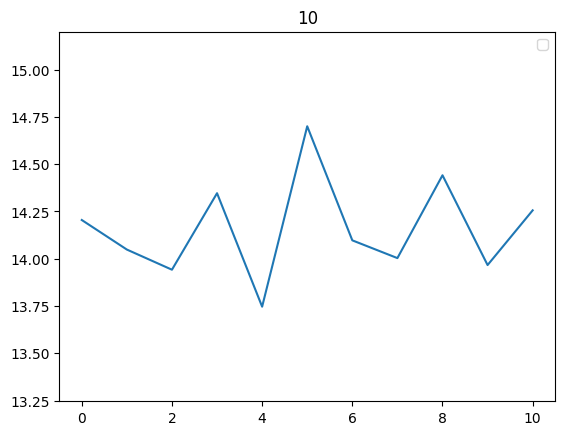

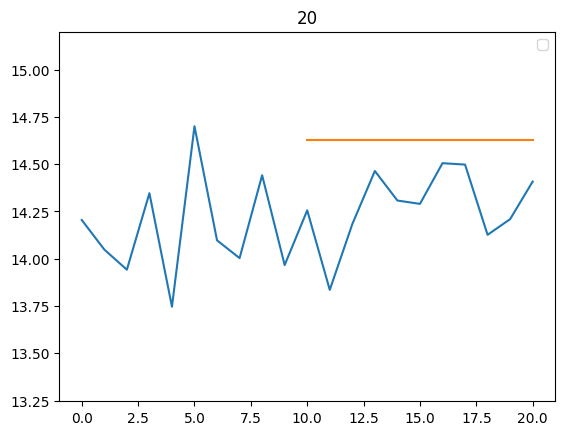

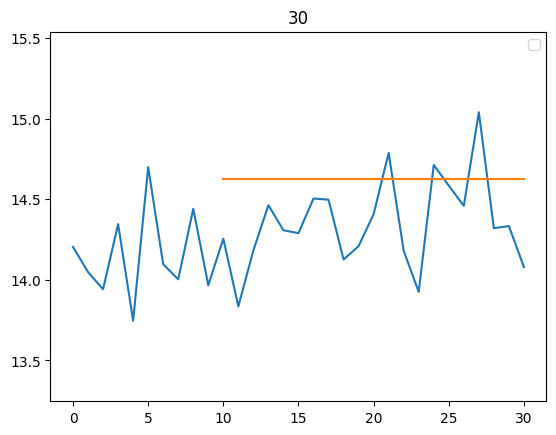

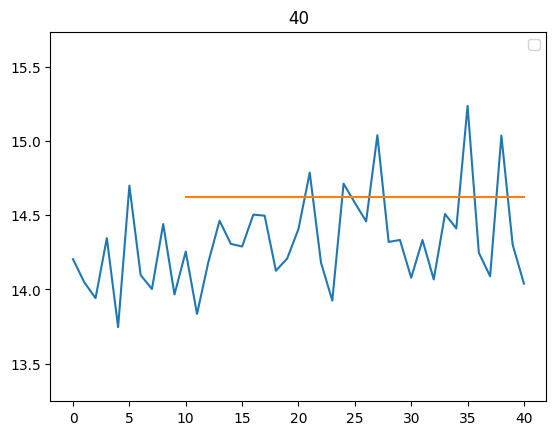

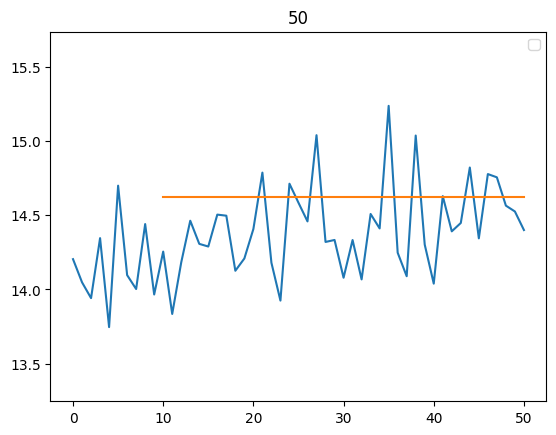

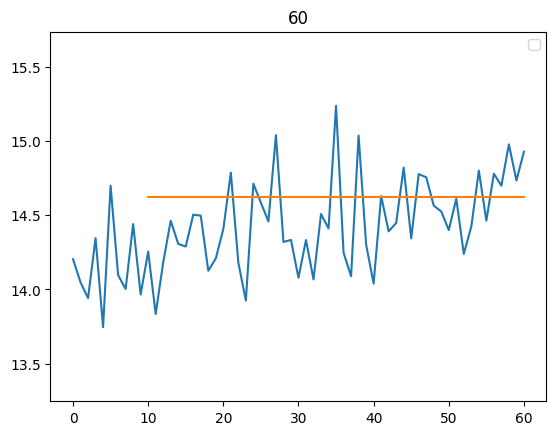

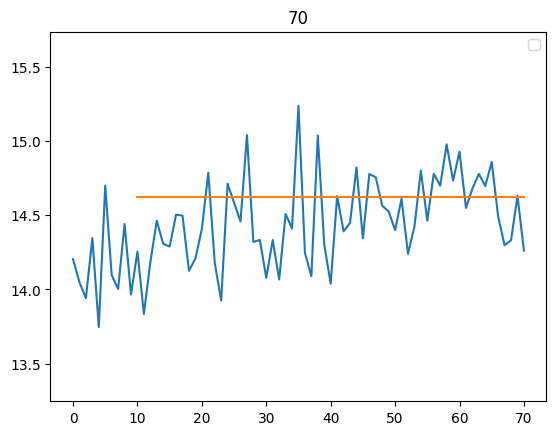

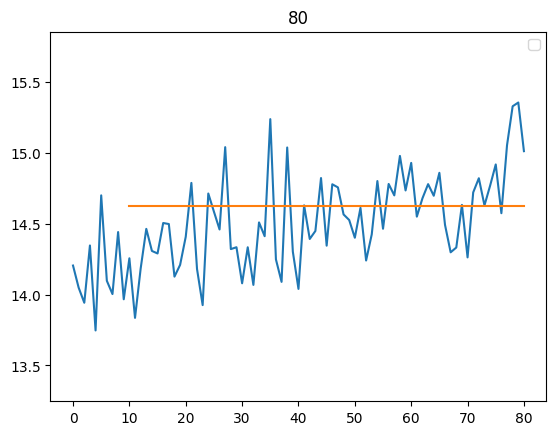

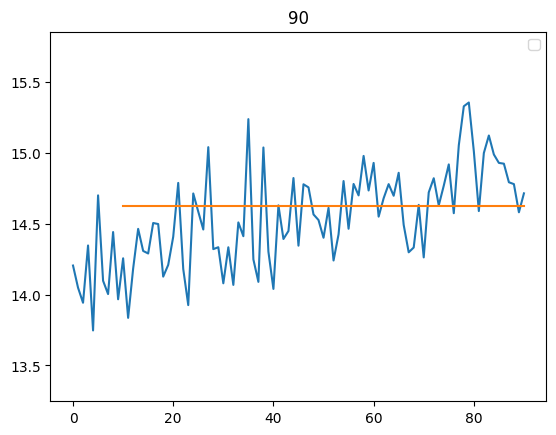

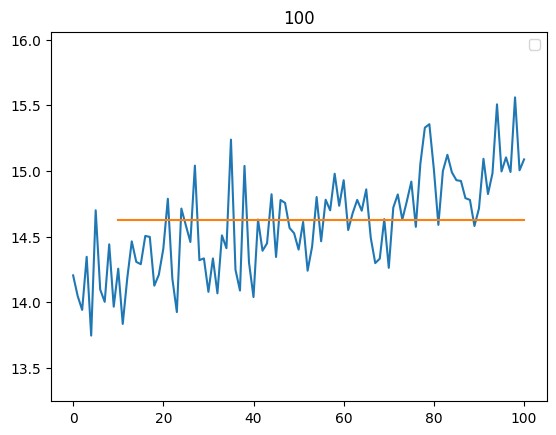

In [13]:
import jax.numpy as jnp
# Initialize model parameters

print('Step test start optimizer')

params_state = model_vars
params_state = flax.jax_utils.replicate(params_state)
optimizer = optax.adam(learning_rate=learning_rate, **adam_kwargs)
opt_state = optimizer.init(model_vars)
opt_state = flax.jax_utils.replicate(opt_state)

def train_step( opt_state, rng, traindata, lr, wdistortion, wbinary, wbgcolor, batch_size, keep_num, threshold, params_state):
  key, rng = random.split(rng)
  rays, pixels = random_ray_batch(
      key, batch_size // n_device, traindata)

  def loss_fn(vars):
    rgb_est, _, rgb_est_b, _, mlp_alpha, weights, points, fake_t, acc_grid_masks = render_rays(
        rays, vars, keep_num, threshold, wbgcolor, rng)

    loss_color_l2 = np.mean(np.square(rgb_est - pixels))
    #loss_color_l2_b = np.mean(np.square(rgb_est_b - pixels))

    loss_acc = np.mean(np.maximum(jax.lax.stop_gradient(weights) - acc_grid_masks,0))
    loss_acc += np.mean(np.abs(vars[1])) *1e-5
    loss_acc += compute_TV(vars[1]) *1e-5

    loss_distortion = np.mean(lossfun_distortion(fake_t, weights)) *wdistortion

    point_loss = np.abs(points)
    point_loss_out = point_loss *1000.0
    point_loss_in = point_loss *0.01
    point_mask = point_loss<(grid_max - grid_min)/point_grid_size/2
    point_loss = np.mean(np.where(point_mask, point_loss_in, point_loss_out))

    return loss_color_l2 + loss_distortion + loss_acc + point_loss, loss_color_l2

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  current_params_state = flax.jax_utils.unreplicate(params_state)
  (total_loss, color_loss_l2), grad = grad_fn(current_params_state)
  total_loss = jax.lax.pmean(total_loss, axis_name='batch')
  color_loss_l2 = jax.lax.pmean(color_loss_l2, axis_name='batch')
  grad = jax.lax.pmean(grad, axis_name='batch')
  #state = state.apply_gradient(grad, learning_rate=lr)
  updates, opt_state =  optimizer.update(grad, opt_state)
  new_params_state = optax.apply_updates(current_params_state, updates)
  return  new_params_state, opt_state, color_loss_l2


#train_pstep = jax.vmap(train_step, axis_name='batch', in_axes=(0, 0, 0, None, None, None, None, None, None, None, None)) #EDIT change pmap to vmap to see print
                     #  static_broadcasted_argnums = (7,8,))
train_pstep = jax.pmap(train_step, axis_name='batch',
                       in_axes=(0, 0, 0, None, None, None, None, None, None, None, None),
                       static_broadcasted_argnums = (7,8,))


print("Training")
for i in tqdm(range(step_init, training_iters + 1)):
  t = time.time()

  lr = lr_fn(i,train_iters_cont, 1e-3, 1e-5)
  wbgcolor = min(1.0, float(i)/50000)
  wbinary = 0.0

  if scene_type=="synthetic":
    wdistortion = 0.0
  elif scene_type=="forwardfacing":
    wdistortion = 0.0 if i<10000 else 0.01
  elif scene_type=="real360":
    wdistortion = 0.0 if i<10000 else 0.001

  if i<=50000:
    batch_size = test_batch_size//4
    keep_num = test_keep_num*4
    threshold = -100000.0
  elif i<=100000:
    batch_size = test_batch_size//2
    keep_num = test_keep_num*2
    threshold = test_threshold
  else:
    batch_size = test_batch_size
    keep_num = test_keep_num
    threshold = test_threshold


  rng, key1, key2 = random.split(rng, 3)
  key2 = random.split(key2, n_device)
  params_state, opt_state, color_loss_l2 = train_pstep(
      opt_state, key2, traindata_p, lr, wdistortion, wbinary, wbgcolor, batch_size, keep_num, threshold, params_state
  )
  #print(params_state)  # Observe intermediate values
  #print(opt_state)  # Observe intermediate values
  #print(color_loss_l2)  # Observe intermediate values

  #print("Test step color_loss_12", color_loss_l2)

  psnrs.append(-10. * np.log10(color_loss_l2[0]))
  iters.append(i)

  if i > 0:
    t_total += time.time() - t

  # Logging
  if (i % 10 == 0) and i > 0: #edit if (i % 10000 == 0) and i > 0:
    gc.collect()

    unreplicated_state = flax.jax_utils.unreplicate(opt_state)
    pickle.dump(unreplicated_state, open(weights_dir+"/s1_"+"tmp_state"+str(i)+".pkl", "wb"))

    print('Current iteration %d, elapsed training time: %d min %d sec.'
          % (i, t_total // 60, int(t_total) % 60))

    print('Batch size: %d' % batch_size)
    print('Keep num: %d' % keep_num)
    t_elapsed = t_total - t_last
    i_elapsed = i - i_last
    t_last = t_total
    i_last = i
    print("Speed:")
    print('  %0.3f secs per iter.' % (t_elapsed / i_elapsed if i_elapsed != 0 else 0)) #edit
    print('  %0.3f iters per sec.' % (i_elapsed / t_elapsed if t_elapsed != 0 else 0)) #edit
    vars = flax.jax_utils.unreplicate(params_state)

    rays = camera_ray_batch( data['test']['c2w'][selected_test_index], data['test']['hwf'])
    gt = data['test']['images'][selected_test_index]
    out = render_loop(rays, vars, test_batch_size)
    rgb = out[0]
    acc = out[1]
    rgb_b = out[2]
    acc_b = out[3]
    psnrs_test.append(-10 * np.log10(np.mean(np.square(rgb - gt))))
    iters_test.append(i)

    print("PSNR:")
    print('  Training running average: %0.3f' % np.mean(np.array(psnrs[-200:])))
    print('  Selected test image: %0.3f' % psnrs_test[-1])

    plt.figure()
    plt.title(i)
    plt.plot(iters, psnrs)
    plt.plot(iters_test, psnrs_test)
    p = np.array(psnrs)
    plt.ylim(np.min(p) - .5, np.max(p) + .5)
    plt.legend()
    plt.savefig(samples_dir+"/s1_"+str(i)+"_loss.png")

    write_floatpoint_image(samples_dir+"/s1_"+str(i)+"_rgb.png",rgb)
    write_floatpoint_image(samples_dir+"/s1_"+str(i)+"_rgb_binarized.png",rgb_b)
    write_floatpoint_image(samples_dir+"/s1_"+str(i)+"_gt.png",gt)
    write_floatpoint_image(samples_dir+"/s1_"+str(i)+"_acc.png",acc)
    write_floatpoint_image(samples_dir+"/s1_"+str(i)+"_acc_binarized.png",acc_b)
    #if(i<training_iters + 1):
    #  params_state = flax.jax_utils.replicate(params_state)
    #  opt_state = flax.jax_utils.replicate(opt_state)



In [14]:
import pandas as pd

df = pd.DataFrame({
    'psnrs': psnrs,
    'iters': iters,
})

df.to_csv(samples_dir+'/s1_train100_results_general_train.csv', index=False)

df = pd.DataFrame({
    'psnrs_test': psnrs_test,
    'iters_test': iters_test
})

df.to_csv(samples_dir+'/s1_train100_results_test_train.csv', index=False)
print(df)

  psnrs_test  iters_test
0  14.626116          10
1  14.626116          20
2  14.626116          30
3  14.626116          40
4  14.626116          50
5  14.626116          60
6  14.626116          70
7  14.626116          80
8  14.626116          90
9  14.626116         100


## Testing

took 1:20:39

In [ ]:
#%%
#%% --------------------------------------------------------------------------------
# ## Run test-set evaluation
#%%
vars = flax.jax_utils.unreplicate(params_state)
gc.collect()

render_poses = data['test']['c2w'][:len(data['test']['images'])]
frames = []
framemasks = []
print("Testing")
for p in tqdm(render_poses):
  out = render_loop(camera_ray_batch(p, hwf), vars, test_batch_size)
  frames.append(out[0])
  framemasks.append(out[1])
psnrs_test = [-10 * np.log10(np.mean(np.square(rgb - gt))) for (rgb, gt) in zip(frames, data['test']['images'])]
print("Test set average PSNR: %f" % np.array(psnrs_test).mean())

#%%
import jax.numpy as jnp
import jax.scipy as jsp

#copied from SNeRG
def compute_ssim(img0,
                 img1,
                 max_val,
                 filter_size=11,
                 filter_sigma=1.5,
                 k1=0.01,
                 k2=0.03,
                 return_map=False):
  """Computes SSIM from two images.
  This function was modeled after tf.image.ssim, and should produce comparable
  output.
  Args:
    img0: array. An image of size [..., width, height, num_channels].
    img1: array. An image of size [..., width, height, num_channels].
    max_val: float > 0. The maximum magnitude that `img0` or `img1` can have.
    filter_size: int >= 1. Window size.
    filter_sigma: float > 0. The bandwidth of the Gaussian used for filtering.
    k1: float > 0. One of the SSIM dampening parameters.
    k2: float > 0. One of the SSIM dampening parameters.
    return_map: Bool. If True, will cause the per-pixel SSIM "map" to returned
  Returns:
    Each image's mean SSIM, or a tensor of individual values if `return_map`.
  """
  # Construct a 1D Gaussian blur filter.
  hw = filter_size // 2
  shift = (2 * hw - filter_size + 1) / 2
  f_i = ((jnp.arange(filter_size) - hw + shift) / filter_sigma)**2
  filt = jnp.exp(-0.5 * f_i)
  filt /= jnp.sum(filt)

  # Blur in x and y (faster than the 2D convolution).
  filt_fn1 = lambda z: jsp.signal.convolve2d(z, filt[:, None], mode="valid")
  filt_fn2 = lambda z: jsp.signal.convolve2d(z, filt[None, :], mode="valid")

  # Vmap the blurs to the tensor size, and then compose them.
  num_dims = len(img0.shape)
  map_axes = tuple(list(range(num_dims - 3)) + [num_dims - 1])
  for d in map_axes:
    filt_fn1 = jax.vmap(filt_fn1, in_axes=d, out_axes=d)
    filt_fn2 = jax.vmap(filt_fn2, in_axes=d, out_axes=d)
  filt_fn = lambda z: filt_fn1(filt_fn2(z))

  mu0 = filt_fn(img0)
  mu1 = filt_fn(img1)
  mu00 = mu0 * mu0
  mu11 = mu1 * mu1
  mu01 = mu0 * mu1
  sigma00 = filt_fn(img0**2) - mu00
  sigma11 = filt_fn(img1**2) - mu11
  sigma01 = filt_fn(img0 * img1) - mu01

  # Clip the variances and covariances to valid values.
  # Variance must be non-negative:
  sigma00 = jnp.maximum(0., sigma00)
  sigma11 = jnp.maximum(0., sigma11)
  sigma01 = jnp.sign(sigma01) * jnp.minimum(
      jnp.sqrt(sigma00 * sigma11), jnp.abs(sigma01))

  c1 = (k1 * max_val)**2
  c2 = (k2 * max_val)**2
  numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
  denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
  ssim_map = numer / denom
  ssim = jnp.mean(ssim_map, list(range(num_dims - 3, num_dims)))
  return ssim_map if return_map else ssim

In [24]:
print("Test set average PSNR: %f" % np.array(psnrs_test).mean())

Test set average PSNR: 14.145709


In [25]:
# Compiling to the CPU because it's faster and more accurate.
#ssim_fn = jax.jit(functools.partial(compute_ssim, max_val=1.), backend="cpu")
# Compiling to the TPU because it can execute in Colab.
ssim_fn_2 = jax.jit(functools.partial(compute_ssim, max_val=1.))


In [26]:
ssim_values = []
for i in range(len(data['test']['images'])):
  ssim = ssim_fn_2(frames[i], data['test']['images'][i])
  ssim_values.append(float(ssim))

print("Test set average SSIM: %f" % np.array(ssim_values).mean())

Test set average SSIM: 0.849094


In [27]:
#%%
#%% --------------------------------------------------------------------------------
# ## Save weights
#%%
pickle.dump(vars, open(weights_dir+"/"+"weights_stage1.pkl", "wb"))

In [28]:
df = pd.DataFrame({
    'psnrs_test': psnrs_test,
    'ssim_values': ssim_values
})

df.to_csv(samples_dir+'/s1_test150_results_test.csv', index=False)
print(df)

    psnrs_test  ssim_values
0    16.895119     0.913128
1    16.803535     0.911750
2     16.63629     0.909986
3    16.429644     0.906776
4    16.201496     0.903755
..         ...          ...
96   14.663204     0.852624
97   14.626116     0.852860
98   14.619088     0.855065
99    14.75706     0.859611
100  14.810838     0.861462

[101 rows x 2 columns]
